# Entrainement finetune de modèles pré-entraînés
Ce notebook présente :
- Pipeline de prétraitement à partir des splits de finetune
- Définition d’un modèle pré-entraîné
- Entraînement et évaluation
- Sauvegarde du meilleur modèle

## Imports & Setup

In [2]:
import os
import pandas as pd
from datetime import date
import subprocess
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, losses, metrics as km
from src.config_utils import load_config
from src.preprocessing_finetune import get_train_datagen, get_val_datagen
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

In [3]:
# Génération du Run ID: date + git hash
today = date.today().isoformat()
commit = subprocess.check_output(["git","rev-parse","--short","HEAD"]).decode().strip()
RUN_ID = f"{today}_{commit}"

# Chargement de la configuration via un chemin relatif
config = load_config('../configs/config_finetune.yaml')
tf.random.set_seed(config['seed'])

print("Run ID :", RUN_ID)

Run ID : 2025-07-05_a0570fa


##  Lecture des splits et création des DataFrames

In [4]:
train_txt = "../splits/all/finetune/train.txt"
val_txt   = "../splits/all/finetune/val.txt"

with open(train_txt) as f: train_files = [l.strip() for l in f]
with open(val_txt)   as f: val_files   = [l.strip() for l in f]

train_df = pd.DataFrame({
    'filename': train_files,
    'class': [os.path.basename(os.path.dirname(p)) for p in train_files]
})

val_df = pd.DataFrame({
    'filename': val_files,
    'class': [os.path.basename(os.path.dirname(p)) for p in val_files]
})

## Générateurs Keras

In [5]:
train_datagen = get_train_datagen(config)
val_datagen   = get_val_datagen()

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='class',
    target_size=tuple(config['input']['size']),
    batch_size=config['input']['batch_size'],
    class_mode='binary',
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col='filename', y_col='class',
    target_size=tuple(config['input']['size']),
    batch_size=config['input']['batch_size'],
    class_mode='binary',
    shuffle=False
)

Found 413 validated image filenames belonging to 2 classes.
Found 89 validated image filenames belonging to 2 classes.


## Construction du modèle

In [6]:
base = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet' if config['model']['pretrained'] else None,
    input_shape=tuple(config['input']['size']) + (3,),
    pooling='avg'
)

x = layers.Dropout(0.4)(base.output)
output = layers.Dense(config['model']['num_classes'])(x)
model = models.Model(inputs=base.input, outputs=output)

## Compilation

In [7]:
opt = optimizers.AdamW(
    learning_rate=float(config['training']['optimizer']['lr']),
    weight_decay=float(config['training']['optimizer']['weight_decay'])
)

loss_fn = losses.BinaryCrossentropy(from_logits=True)

metric_list = [
    'accuracy',
    km.Precision(name='precision_toxic'),
    km.Recall(name='recall_toxic'),
    km.AUC(name='roc_auc'),
    km.AUC(name='pr_auc', curve='PR')
]

model.compile(optimizer=opt, loss=loss_fn, metrics=metric_list)

## Callbacks et chemins

In [10]:
ckpt_dir = "../outputs/checkpoints/all/finetune"
os.makedirs(ckpt_dir, exist_ok=True)

ckpt_path = os.path.join(ckpt_dir, 'finetune_resnet50.keras')

es = callbacks.EarlyStopping(
    monitor=config['training']['callbacks']['early_stopping']['monitor'],
    mode=config['training']['callbacks']['early_stopping']['mode'],
    patience=config['training']['callbacks']['early_stopping']['patience']
)

mc = callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    monitor=config['training']['callbacks']['model_checkpoint']['monitor'],
    mode=config['training']['callbacks']['model_checkpoint']['mode'],
    save_best_only=True
)

## Calcul des poids de classes

In [12]:
cw = {
    0: config['loss']['class_weights']['non_toxic'],
    1: config['loss']['class_weights']['toxic']
}

## Entraînement

In [13]:
history = model.fit(
    train_gen,
    epochs=config['training']['epochs'],
    validation_data=val_gen,
    callbacks=[es, mc],
    class_weight=cw
)

/Users/titou/Library/Mobile Documents/com~apple~CloudDocs/Documents/UniNe/Projet de Bachelor/Git/microcoleus-project/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.5569 - loss: 0.3494 - pr_auc: 0.6612 - precision_toxic: 0.6561 - recall_toxic: 0.4509 - roc_auc: 0.6133 - val_accuracy: 0.5843 - val_loss: 1.3707 - val_pr_auc: 0.5843 - val_precision_toxic: 0.5843 - val_recall_toxic: 1.0000 - val_roc_auc: 0.5000
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8288 - loss: 0.2172 - pr_auc: 0.8681 - precision_toxic: 0.8833 - recall_toxic: 0.8039 - roc_auc: 0.8512 - val_accuracy: 0.4157 - val_loss: 1.2446 - val_pr_auc: 0.5843 - val_precision_toxic: 0.0000e+00 - val_recall_toxic: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.8926 - loss: 0.1195 - pr_auc: 0.9445 - precision_toxic: 0.9544 - recall_toxic: 0.8654 - roc_auc: 0.9243 - val_accuracy: 0.5843 - val_loss: 0.7748 - val_pr_auc: 0.5843 - val_precision_toxic: 0.5843 - val_recall_toxic: 1.0000 - val_roc_auc: 0.5000
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 

## Sauvegarde de l’historique

In [14]:
hist_path = '../outputs/checkpoints/all/finetune/history_finetune_resnet50.pkl'
pd.to_pickle(history.history, hist_path)

## Tracé des courbes d’entraînement

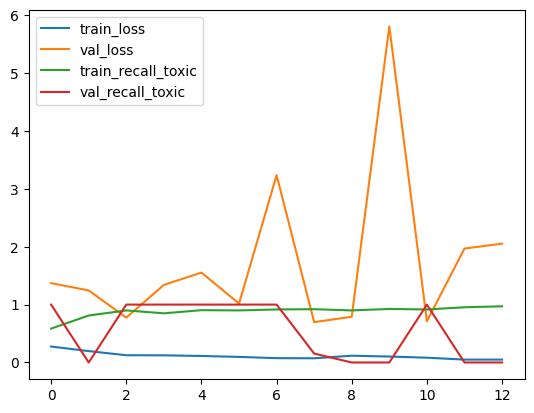

In [16]:
hist = pd.read_pickle('../outputs/checkpoints/all/finetune/history_finetune_resnet50.pkl')
plt.plot(hist['loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.plot(hist['recall_toxic'], label='train_recall_toxic')
plt.plot(hist['val_recall_toxic'], label='val_recall_toxic')
plt.legend()
plt.show()
